#***ADECUACIÓN DE BASE DE DATOS***

---



---



In [1]:

!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.2 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=f90a364c50e75e8550e271d14c09f14b039dd563304c3cd9648d71aba239c40a
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import numpy as np
import pandas as pd 

from sklearn import preprocessing # Data Scaling
from sklearn import decomposition #PCA
from sklearn.cluster import KMeans

import chart_studio
from chart_studio import plotly as py
import plotly.graph_objs as go
import chart_studio.tools as tls
import plotly.express as px

In [ ]:
#Login Chart-Studio Plotly
username = 'gabrielfernande.z'
api_key = '5HgFCCvxjLneWCyIpeuI'

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
df = pd.read_csv('/content/drive/My Drive/Agencia/autopartes/autopartes_imports.csv')

In [ ]:
df1 = df[['year', 'reporter_code','reporter', 'reporter_iso', 'partner_code', 'partner',
       'partner_iso', 'commodity_code','commodity', 'trade_value_usd']]

In [ ]:
df1['commodity_code'].astype('int', errors='ignore')
ncm = [71320.0] 
    
# selecting rows based on condition 
df1.loc[df1['commodity_code'].isin(ncm)]

In [ ]:
df1['trade_value_usd'] = df1['trade_value_usd'] / 1000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Python: sorting and aggregations
df_agg = df1.sort_values(by=['reporter_iso','year'], ascending = [True, True]).groupby(['reporter_iso','year',]).agg(
    first_value =  ('trade_value_usd', 'first'),
    last_value =  ('trade_value_usd', 'last'),
    total =  ('trade_value_usd', sum),
    promedio = ('trade_value_usd', 'mean'))

In [ ]:
df_agg['var_impo'] = ((df_agg['last_value'] / df_agg['first_value'])-1) * 100

In [ ]:
#Calculo mediana
mediana = df_agg['promedio'].median()
mediana
#Nueva columna (feature, variable), si promedio de importaciones (totales) es mayor a la Mediana
df_agg['mayor_mediana'] = np.where(df_agg['promedio'] < mediana, "NO", "SI")

In [ ]:
#Nueva columna (feature, variable), si promedio de importaciones (totales) es mayor a la Mediana
df_agg['mayor_mediana'] = np.where(df_agg['promedio'] < mediana, "NO", "SI")

In [ ]:
UE = ["USA","DEU","AUT","BEL","BGR","CYP","HRV","DNK","SVK","SVN","ESP","EST",
      "FIN","FRA","GRC","HUN","IRL","ITA","LVA","LTU","LUX","MLT","MCO","NLD",
      "POL","PRT","GBR","CZE","ROU","SMR","SWE"]

In [ ]:
# Genero columna de partners con partner_iso
result = []
for value in df1['partner_iso']:
  if value == "ARG":
    result.append("ARG")
  elif value == "CHN":
    result.append("CHN")
  elif value in UE:
    result.append("UE")
  else:
    result.append("Resto")
   
df1["procedencia"] = result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
# i) Creo df de totales y ii) desagregago por partners (totales y media)
df_salud_proc = df1.sort_values(by=['reporter_iso'], ascending = [True]).groupby(['reporter_iso']).agg(total =  ('trade_value_usd', sum),
                                                                                                    media_value = ('trade_value_usd', 'mean'),
                                                                                                    first = ('trade_value_usd', 'first'),
                                                                                                    last =('trade_value_usd', 'last'),
                                                                                                    last_year = ('year', 'last'))

df_salud_proc2 = df1.sort_values(by=['reporter_iso'], ascending = [True]).groupby(['reporter_iso','procedencia']).agg(total =  ('trade_value_usd', sum),
                                                                                                                   media =('trade_value_usd', 'mean'),
                                                                                                                   first = ('trade_value_usd', 'first'),
                                                                                                                   last =('trade_value_usd', 'last'))

df_salud_proc2 = df_salud_proc2.unstack()

df_salud_proc2.columns = ['ARG_sum','UE_sum','CHN_sum','Resto_sum',
                          'ARG_media','UE_media','CHN_media','Resto_media',
                          'ARG_first','UE_first','CHN_first','Resto_first',
                          'ARG_last','UE_last','CHN_last','Resto_last']
# Merge i) y ii)
df_salud_proc3 = pd.merge(df_salud_proc, df_salud_proc2, left_index=True, right_index=True)

#Calculo participacion de cada partner por iso_pais
df_salud_proc3['ARG_part'] = (df_salud_proc3['ARG_sum'] / df_salud_proc3['total'])*100  
df_salud_proc3['UE_part'] = (df_salud_proc3['UE_sum'] / df_salud_proc3['total'])*100  
df_salud_proc3['CHN_part'] = (df_salud_proc3['CHN_sum'] / df_salud_proc3['total'])*100  
df_salud_proc3['Resto_part'] = (df_salud_proc3['Resto_sum'] / df_salud_proc3['total'])*100  

#Calculo variaciones de importaciones para el iso_pais, mediana, y si el pais está encima o debajo de la mediana
df_salud_proc3['var_impo'] = ((df_salud_proc3['last'] / df_salud_proc['first'])-1)*100

mediana = df_salud_proc3['media_value'].median()
df_salud_proc3['mayor_median'] = np.where(
    df_salud_proc['media_value'] < mediana, "NO", "SI") 

In [ ]:
df_salud_proc3 = df_salud_proc3.reset_index()

In [ ]:
df_salud_proc3['ARG_part'] = df_salud_proc3['ARG_part'].fillna(0).astype(int)

impo_global = df_salud_proc3[['reporter_iso','total', 'media_value', 'ARG_part', 'UE_part', 'CHN_part', 'Resto_part', 'last_year']]
impo_global = impo_global.round(2)
#impo_global.columns = ['Total', 'Mean', 'Part. Arg', 'Part. UE', 'Part. China', 'Part. Rest', 'Last Year' ]

In [ ]:
impo_global = impo_global.reset_index()

In [ ]:
filename = '/content/drive/My Drive/Agencia/equipamiento_medico/cod_paises.csv' 
f = open(filename, "r")
cod_paises = pd.read_csv(filename, sep=',', encoding= 'unicode_escape')

In [ ]:
cod_paises.columns = ['reporter_iso','continente','reporter','zona']

In [ ]:
#Merge entre base con el listado de codigos de paises
df_salud_proced = pd.merge(df_salud_proc3, cod_paises, on = 'reporter_iso')

In [ ]:
#Fillna para conservar la variable ARG_part y no excluir tantos paises en el PCA
df_salud_proced[['ARG_sum','ARG_media','ARG_first','ARG_part','ARG_last','UE_part']] = df_salud_proced[['ARG_sum','ARG_media','ARG_first','ARG_part','ARG_last', 'UE_part']].fillna(0).astype(int)

In [ ]:
df_salud_proced.shape

(166, 31)

In [ ]:
#Guardo como CSV
df_salud_proced.to_csv("/content/drive/MyDrive/Agencia/autopartes/df_salud_proced.csv", index=False)

#**CLUSTERIZACIÓN**

---



---

In [ ]:
import missingno as msno

In [ ]:
#Import economic, demografic and health spending (public & private) (World Bank Data Base)
filename = '/content/drive/My Drive/Agencia/autopartes/variables.xlsx' 
f = open(filename, "r")
data_gral = pd.read_excel(filename)#, sep=',', encoding= 'unicode_escape')

In [ ]:
#Impute NaN with zeros
#data_gral['C2'] = data_gral['C2'].replace(0, np.nan)
#data_gral['S7'] = data_gral['S7'].fillna(0).astype(int)

In [ ]:
#Drop C5 - Correlation
#data_gral = data_gral.drop('C5', axis = 1)

In [ ]:
data_gral.columns

Index(['iso_code', 'ied', 'idl', 'x_pbi', 'm_pbi', 'pbi_growth', 'tasa_min',
       'inflation', 'deval', 'poblacion', 'tcr', 'prima'],
      dtype='object')

In [ ]:
data_gral=data_gral.rename(columns = {'iso_code':'reporter_iso'})

In [ ]:
#Select columns from imports dataframe
df_salud_sub = df_salud_proced[['media_value', 'ARG_part', 'UE_part','CHN_part','reporter_iso']]

#Merge
df_cluster_vf = pd.merge(data_gral, df_salud_sub, on = 'reporter_iso', how = 'inner')

In [ ]:
df_cluster_vf.columns

Index(['reporter_iso', 'ied', 'idl', 'x_pbi', 'm_pbi', 'pbi_growth',
       'tasa_min', 'inflation', 'deval', 'poblacion', 'tcr', 'prima',
       'media_value', 'ARG_part', 'UE_part', 'CHN_part'],
      dtype='object')

In [ ]:
#Fillna para conservar la variable ARG_part y no excluir tantos paises en el PCA
df_cluster_vf[['UE_part']] = df_cluster_vf[['UE_part']].fillna(0).astype(int)
df_cluster_vf = df_cluster_vf.drop('prima', axis = 1)

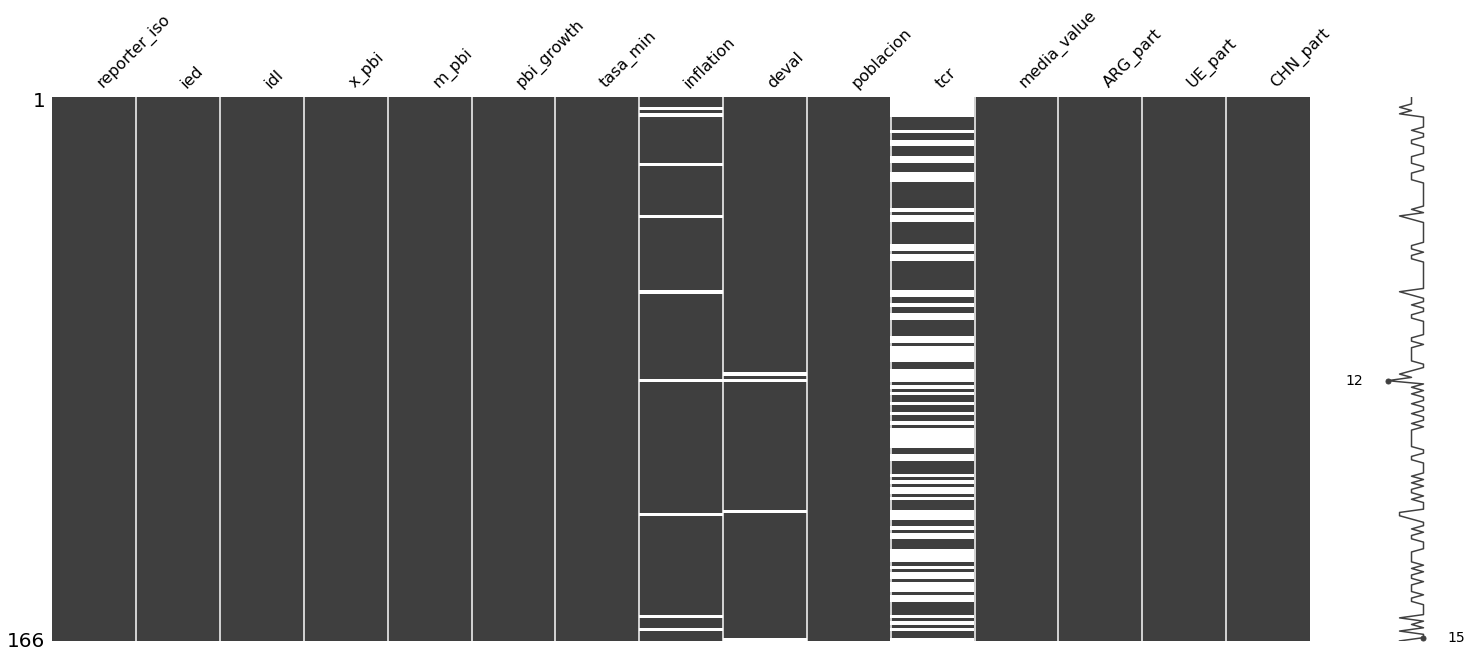

In [ ]:
msno.matrix(df_cluster_vf)

In [ ]:
#Drop NaN (sine qua non condition to apply PCA)
data_pc = df_cluster_vf.dropna()
data_pc = data_pc.set_index('reporter_iso')
#Subset PCA
data_pc_slice = data_pc.iloc[:,0:15]
columns_slice = data_pc_slice.columns
data_pc_slice = data_pc_slice.astype(float)
data_pc_slice.shape

(88, 14)

In [ ]:
data_pc_slice.columns

Index(['ied', 'idl', 'x_pbi', 'm_pbi', 'pbi_growth', 'tasa_min', 'inflation',
       'deval', 'poblacion', 'tcr', 'media_value', 'ARG_part', 'UE_part',
       'CHN_part'],
      dtype='object')

In [ ]:
#Preprossecing data
#data_x = preprocessing.scale(data_pc_slice)
#data_x = pd.DataFrame(data_x, columns = columns_slice)

data_x = preprocessing.StandardScaler().fit_transform(data_pc_slice)
data_x = pd.DataFrame(data_x, columns = columns_slice)

In [ ]:
#PRINCIPAL COMPONENTS ANALYSIS
pca = decomposition.PCA(n_components=5)
pca.fit(data_x)
comp = pca.transform(data_x)
comp_df = pd.DataFrame(comp, columns=['PC1', 'PC2', 'PC3','PC4', 'PC5'])

In [ ]:
#Dataframa WB variables, Imports and PCs
df_slice_comp = pd.merge(data_x, comp_df, left_index=True, right_index=True)

In [ ]:
#KMEANS CLUSTERING
kmean = KMeans(n_clusters = 5, max_iter = 10000, n_init = 50)
kmean.fit(comp)

KMeans(max_iter=10000, n_clusters=5, n_init=50)

In [ ]:
#Cluster identification
#kMEANS labels to dataframe
clusters = kmean.labels_
clusters = pd.DataFrame(clusters, columns = ['cluster'])

#iso codes 
data_pc = data_pc_slice.reset_index() 

#Unir iso_pais, con df_slice_comp y cluster
df_vf = pd.merge(data_pc, comp_df, left_index=True, right_index=True)
df_vf = pd.merge(df_vf, clusters, left_index=True, right_index=True)

#Select columns
features = df_vf.columns[1:-6]

In [ ]:
df_vf.head()

,reporter_iso,ied,idl,x_pbi,m_pbi,pbi_growth,tasa_min,inflation,deval,poblacion,...,media_value,ARG_part,UE_part,CHN_part,PC1,PC2,PC3,PC4,PC5,cluster
0,ARM,1.719522,2.61,36.493540,47.778181,2.620000,6.6520,1.987650,0.009589,2950727.8,...,0.130200,0.0,5.0,79.590636,-0.142466,-0.479572,-0.007097,-0.345934,-0.117674,1
1,ATG,8.555849,0.00,63.893150,63.455502,0.038858,9.9100,1.211758,0.000000,96254.0,...,0.065363,0.0,0.0,50.379799,0.279068,-1.420348,-1.436218,-0.334010,-0.735145,2
2,AUS,3.154876,3.75,22.103695,21.101167,2.003571,2.4780,1.743104,-0.000645,24966893.4,...,3.171010,0.0,3.0,65.132667,0.164650,2.317408,0.145269,-0.153602,-0.115053,1
3,AUT,-3.501654,4.03,53.755083,50.500871,0.301260,5.4780,1.775119,-0.012567,8834307.8,...,0.975293,0.0,0.0,51.016798,0.820047,1.511391,-0.548973,-0.039314,-0.012089,1
4,BDI,0.060653,2.06,7.522745,28.499084,0.729995,12.9275,5.639067,0.036144,11182349.8,...,0.047216,0.0,11.0,87.459230,-2.088261,-1.365775,0.234427,-0.730136,0.306506,2


In [ ]:
features

Index(['ied', 'idl', 'x_pbi', 'm_pbi', 'pbi_growth', 'tasa_min', 'inflation',
       'deval', 'poblacion', 'tcr', 'media_value', 'ARG_part', 'UE_part',
       'CHN_part'],
      dtype='object')

In [ ]:
#Loadings matrix: correlation matrix
loadings_matrix = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2','PC3','PC4', 'PC5'], index=features)
loadings_matrix = loadings_matrix.reset_index()
loadings_matrix.columns = ['Referencia', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'] 
#loadings_matrix = loadings_matrix.astype(str)

#Variables description
variables = {
    'Referencia': ['ied', 'idl', 'x_pbi', 'm_pbi', 'pbi_growth', 'tasa_min', 'inflation','deval', 'poblacion', 'tcr', 'media_value', 'ARG_part', 'UE_part', 'CHN_part'],
    'Descripción': ['Inversión Extranjera Directa','Índice de Desempeño Logístico','Exportaciones de Bienes y Servicios (% del PIB)','Importaciones de Bienes y Servicios (% del PIB)',
                    'Crecimiento del PIB (% anual)', 'Tasa Mínima Arancelaria (%)', 'Inflación','Tasa de Devaluación Promedio', 'Población Total','Tipo de Cambio Real Efectivo','Importaciones Promedio 2016-2020',
                    'Participación argentina en importaciones', 'Participación UE y USA en importaciones', 'Participación china en importaciones'
                    ]
}

variables = pd.DataFrame(variables)

#Merge loadings and variables descriptions
loadings_matrix_detalle = pd.merge(loadings_matrix, variables, on = 'Referencia')

#***PLOTS***

---



---

In [ ]:
df_vf = pd.merge(df_vf, cod_paises, on = 'reporter_iso', how = 'inner')

In [ ]:
df_vf.iloc[:, 1:20] = df_vf.iloc[:, 1:20].round(2) # Remember that Python does not slice inclusive of the ending index.

In [ ]:
df_vf.reporter = df_vf.reporter.replace('Reino Unido de Gran Bretaña e Irlanda del Norte', 'Reino Unido')


In [ ]:
# PCA and Clusters Scatter Plot


fig = px.scatter(df_vf, x=df_vf['PC1'], y=df_vf['PC2'], color=df_vf['cluster'],hover_data = ['reporter_iso', 'reporter','media_value', 'ARG_part', 'UE_part','CHN_part'], color_discrete_sequence=["green", "blue", "yellow", "magenta", "black"],
                 labels={'PC1': 'Componente Principal #1', 'PC2':'Componente Principal #2'})

#py.iplot(fig)
fig.show()

In [ ]:
df_comp = df_vf[['PC1', 'PC2', 'PC3', 'PC4', 'PC5','reporter', 'cluster']]

In [ ]:
df_vf.reporter = df_vf.reporter.replace('Hong Kong (región administrativa especial de China)', 'Hong Kong')
df_vf.reporter = df_vf.reporter.replace('Macao (región administrativa especial de China)', 'Macao')
df_comp.reporter = df_comp.reporter.replace('Hong Kong (región administrativa especial de China)', 'Hong Kong')
df_comp.reporter = df_comp.reporter.replace('Macao (región administrativa especial de China)', 'Macao')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_vf.reporter = df_vf.reporter.replace('Hong Kong (región administrativa especial de China)', 'Hong Kong')
df_vf.reporter = df_vf.reporter.replace('Macao (región administrativa especial de China)', 'Macao')

In [ ]:
# Top 20 reporters. Anual Mean 2017-2021
df = df_vf
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)

fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Principales importadores a nivel global: top 20 importadores. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})
fig.show()

In [ ]:
#LATAM imports. Anual Mean 2016-2020 

latam = ['ARG','ABW','BHS','BRB','BLZ','BMU','BOL','BRA','CHL','COL','CRI','CUB','ECU','SLV','GTM',
         'GUF','GUY','HTI','HND','FLK','JAM','MEX','NIC','PAN','PRY','PER','PRI','DOM','SUR','TTO',
         'URY','VEN']

df = df_salud_proced.loc[df_salud_proced['reporter_iso'].isin(latam)]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)

fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Importaciones de Latinoamérica. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})


#py.iplot(fig)
fig.show()

In [ ]:
#Argentina imports. Anual Mean 2016-2020 

# SLICING & GROUPING
imp_arg = df1[df1['partner_iso'] == 'ARG']
imp_arg = imp_arg.groupby(['reporter']).agg(total =  ('trade_value_usd', sum),
                                                          media_value =('trade_value_usd', 'mean'),
                                                          first = ('trade_value_usd', 'first'),last =('trade_value_usd', 'last'), last_year = ('year','last'))
imp_arg = imp_arg.reset_index()

imp_arg.reporter = imp_arg.reporter.replace('Bolivia (Plurinational State of)', 'Bolivia')

df = imp_arg
sd = df.nlargest(15,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)

fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter','media_value', 'first', 'last','last_year'],
             height=600,
             title='A qué países le exporta Argentina? Top 15 importadores. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
#Loadings matrix to Table
df = loadings_matrix
df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].round(3) 

fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4,5,6],
    columnwidth = [110, 80, 80, 80, 80, 80],
    header=dict(values=list(df.columns),
                fill_color='rgba(92,140,164)',
                align='center'),
    cells=dict(values=[df.Referencia, df.PC1, df.PC2, df.PC3, df.PC4, df.PC5],
               fill_color='rgba(196,196,196)',
               align='center'))
])
py.iplot(fig)
#fig.show()

In [ ]:
#Variables description to Table
df = variables 
fig = go.Figure(data=[go.Table(
    columnorder = [1,2],
    columnwidth = [80, 200],
    header=dict(values=list(df.columns),
                fill_color='rgba(92,140,164)',
                align='center'),
    cells=dict(values=[df.Referencia, df.Descripción],
               fill_color='rgba(196,196,196)',
               align='center'))
])
py.iplot(fig)
#fig.show()

In [ ]:
df2 = pd.merge(impo_global, cod_paises, on = 'reporter_iso', how = 'inner')
df2.reporter = df2.reporter.replace('Reino Unido de Gran Bretaña e Irlanda del Norte', 'Reino Unido')

In [ ]:
df2 = df2.set_index('index')
df2 = df2[['reporter', 'total', 'media_value', 'ARG_part', 'UE_part','CHN_part', 'Resto_part', 'last_year']]
df2=df2.rename(columns = {'total':'total (Mill.)'})

In [ ]:
#Imports general data

fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4,5,6,7,8],
    columnwidth = [110, 80, 80, 80, 80, 80, 80],
    header=dict(values=list(df2.columns),
                fill_color='rgba(92,140,164)',
                align='center'),
    cells=dict(values= [df2.reporter, df2['total (Mill.)'], df2.media_value, df2.ARG_part, df2.UE_part, df2.CHN_part, df2.Resto_part, df2.last_year],
               fill_color='rgba(196,196,196)',
               align='center'))
])
py.iplot(fig)
#fig.show()

In [ ]:
# RANKING PC1
df = df_vf
sd = df.nlargest(20,'PC1')
fd = sd.sort_values(by='PC1', ascending = True)

fig = px.bar(fd, x="PC1", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Ranking de países según PC1',
             labels={'PC1': 'Componente Principal #1', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #1 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([0])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #1. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #2 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([1])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #2. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #3 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([2])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #3. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #4 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([3])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #4. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #5 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([4])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #5. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
df_world = df1.loc[df1['partner_iso'].isin(['WLD'])]
df_world = df_world.sort_values(by=['reporter'], ascending = [True]).groupby(['reporter','reporter_iso', 'year']).agg(total =  ('trade_value_usd', sum))
df_world['%-Change']=df_world.groupby(['reporter', 'reporter_iso'])['total'].apply(lambda x: x/x.shift(1)-1).fillna(0)*100
df_mean_var = df_world.sort_values(by=['reporter'], ascending = [True]).groupby(['reporter','reporter_iso']).agg(mean_var =  ('%-Change', 'mean'))
df_mean_var['mean_var'] = df_mean_var['mean_var'].round(2)

In [ ]:
#Merge de bases de variables + importaciones
df_pc_var = pd.merge(df_vf, df_mean_var, on = 'reporter_iso', how = 'inner')
df_pc_var.shape

(88, 25)

In [ ]:
# value column equals to 0.0
indexNames = df_pc_var[(df_pc_var['reporter'] == 'Bahrein')].index
# Delete these row indexes from dataFrame
df_pc_var.drop(indexNames , inplace=True)

In [ ]:
# value column equals to 0.0
indexNames = df_pc_var[(df_pc_var['reporter'] == 'Burundi')].index
# Delete these row indexes from dataFrame
df_pc_var.drop(indexNames , inplace=True)

In [ ]:
# value column equals to 0.0
indexNames = df_pc_var[(df_pc_var['reporter'] == 'Santa Lucía')].index
# Delete these row indexes from dataFrame
df_pc_var.drop(indexNames , inplace=True)

In [ ]:

# PCA and Clusters Scatter Plot

fig = px.scatter(df_pc_var, x=df_pc_var['PC1'], y=df_pc_var['mean_var'], color=df_pc_var['cluster'],hover_data = ['reporter_iso', 'reporter'], color_discrete_sequence=px.colors.qualitative.Antique,
                 labels={'PC1': 'Componente Principal #1', 'mean_var':'Variación % - Promedio anual'})

#py.iplot(fig)
fig.show()